# Content Filtering

## Imports / Dataset Pre-processing

In [1]:
import os
import torch
import pandas as pd
from PIL import Image
import clip
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [2]:
# Load product data (Sheet1)
excel_path = "../dataset_sheet_content_filtering.xlsx"
df = pd.read_excel(excel_path, sheet_name='Sheet1')

In [3]:
# Load personas data
# Load product data (Sheet1)
excel_path = "../dataset.xlsx"
persona_df = pd.read_excel(excel_path, sheet_name='Copy of Sheet1')

In [4]:
image_folder = "../dataset/"
df["text_embedding"] = None
df["image_embedding"] = None

### Image and Text Embeddings

In [5]:
#load clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [6]:
for idx, row in df.iterrows():
    # ----------------------------------
    # a) Find the corresponding image file
    # ----------------------------------
    # used idx + 2 as image_number ID
    image_number = idx + 2
    possible_extensions = [".jpg", ".png"]

    image_path = None
    for ext in possible_extensions:
        candidate_path = os.path.join(image_folder, f"{image_number}{ext}")
        if os.path.isfile(candidate_path):
            image_path = candidate_path
            break

    if not image_path:
        print(f"Warning: No image found for row {idx}, looking for {image_number}.jpg or .png")
        continue

    # ----------------------------------
    # b) Load text and image
    # ----------------------------------
    text_str = f"{row['brand']} {row['name']} {row['description']}"
    text_str = text_str[:77]

    # Load and preprocess the image
    raw_image = Image.open(image_path).convert("RGB")
    image_input = preprocess(raw_image).unsqueeze(0).to(device)

    # ----------------------------------
    # c) Encode text and image using CLIP
    # ----------------------------------
    with torch.no_grad():
        # Text encoding
        text_tokens = clip.tokenize([text_str]).to(device)  # batch with 1 item
        text_embeds = model.encode_text(text_tokens)
        # Image encoding
        image_embeds = model.encode_image(image_input)

    # Convert embeddings to CPU and then to list (or NumPy array) for easier storage
    text_embedding = text_embeds[0].cpu().numpy().tolist()
    image_embedding = image_embeds[0].cpu().numpy().tolist()

    # ----------------------------------
    # d) Insert embeddings into the DataFrame
    # ----------------------------------
    df.at[idx, "text_embedding"] = text_embedding
    df.at[idx, "image_embedding"] = image_embedding

In [7]:
df["image_path"] = [
    (Path(image_folder) / f"{i+2}.png").as_posix()
    for i in df.index
]

In [12]:
df.shape

(62, 11)

In [13]:
df.head()

,brand,name,description,price,user,gender,color,is_top,text_embedding,image_embedding,image_path
0,Forever 21,Twill Wide-Leg Cargo Pants,A pair of twill pants featuring contrasting to...,24.49,vivian,F,black,0,"[0.2016282081604004, 0.28957486152648926, -0.4...","[0.12176838517189026, 0.12389539927244186, -0....",../dataset/2.png
1,gifteabox,"Denim for all seasons, 3-length vintage Faded ...",Country of Origin : China(OEM)\nMaterial : 100...,25.68,megan,F,blue,0,"[0.29881617426872253, 0.028792236000299454, -0...","[0.07662021368741989, 0.6227589845657349, -0.1...",../dataset/3.png
2,Forever 21,Mid-Rise Wide-Leg Cargo Pants,A pair of twill pants featuring a mid-rise wai...,24.49,vivian,F,green,0,"[0.29192599654197693, 0.23970846831798553, -0....","[0.0571666918694973, 0.08652636408805847, -0.2...",../dataset/4.png
3,binary01,Fine layered check blouse,Country of Origin : China(OEM)\nMaterial : Cot...,33.53,megan,F,gray,1,"[0.06796179711818695, 0.4492296576499939, -0.2...","[-0.25351011753082275, 0.18703745305538177, -0...",../dataset/5.png
4,wonderwonder,Blena Heart Strap Button Lace Cropped Sleevele...,Country of Origin : Korea/China(OEM)\nMaterial...,24.57,megan,F,white,1,"[0.24646836519241333, -0.13289624452590942, -0...","[-0.08947891741991043, 0.208067387342453, -0.0...",../dataset/6.png


### One-hot encodings (may not be needed if using text/image embeddings)

In [8]:
# One-hot encode brand, gender, color (single categorical columns).
df_brand = pd.get_dummies(df["brand"], prefix="brand")
df_gender = pd.get_dummies(df["gender"], prefix="gender")
df_color = pd.get_dummies(df["color"], prefix="color")

# Concatenate all one-hot columns into a final feature matrix.
df_item_features = pd.concat([df_brand, df_gender, df_color], axis=1)
# df_item_features.index = df['ID']  # keep row number as index

In [9]:
df_item_features.columns

Index(['brand_A&F', 'brand_Aritzia', 'brand_Brandy Mellville',
       'brand_Brandy Melville', 'brand_Champion', 'brand_Forever 21',
       'brand_H&M', 'brand_Hollister', 'brand_Lewkin', 'brand_Nike',
       'brand_Tommy Hilfiger', 'brand_Uniqlo',
       'brand_White House Black Market', 'brand_Zara', 'brand_binary01',
       'brand_gifteabox', 'brand_wonderwonder', 'gender_F', 'gender_M',
       'color_beige', 'color_black', 'color_blue', 'color_brown', 'color_gray',
       'color_green', 'color_maroon', 'color_navy', 'color_pink',
       'color_purple', 'color_tan', 'color_white'],
      dtype='object')

In [11]:
df_item_features.head()

,brand_A&F,brand_Aritzia,brand_Brandy Mellville,brand_Brandy Melville,brand_Champion,brand_Forever 21,brand_H&M,brand_Hollister,brand_Lewkin,brand_Nike,...,color_blue,color_brown,color_gray,color_green,color_maroon,color_navy,color_pink,color_purple,color_tan,color_white
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Creating NumPy Array for useful features

Note: Unsure what kinds of features are most useful. Is it better to just let the algorithm use the text and image embeddings, or should we retrieve more structured data out of the embeddings (i.e. brand, color, clothing type, top vs. bottom, gender, etc.)?

In [12]:
all_item_vectors = []

# We'll iterate over every row in df (each row = one item).
for idx in df.index:
    # 1) Get the one-hot vector from df_item_features
    # cat_vector = df_item_features.loc[idx].values  # shape: (num_one_hot_cols,)

    # 2) Get the text & image embeddings
    text_vector = np.array(df.at[idx, "text_embedding"])  # shape: (D1,)
    image_vector = np.array(df.at[idx, "image_embedding"])  # shape: (D2,)

    # 3) Concatenate them into one vector
    # combined_vector = np.concatenate([cat_vector, text_vector, image_vector])
    combined_vector = np.concatenate([text_vector, image_vector])

    # 4) Store or collect this combined vector
    all_item_vectors.append(combined_vector)

# Convert the list of vectors into a 2D array:
# shape = (num_items, num_one_hot_cols + D1 + D2)
all_item_vectors = np.array(all_item_vectors)


In [13]:
all_item_vectors.shape

(62, 1024)

## Recommendations Implementation

### Cosine similarity Function

In [14]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def recommend_items(liked_indices, all_item_vectors, top_n=5):
    """
    Recommends top N items based on content-based filtering using cosine similarity.
    
    Parameters:
    - liked_indices (list): Indices of items the user likes.
    - all_item_vectors (numpy.ndarray): Matrix where each row is an item's feature vector.
    - top_n (int): Number of recommendations to return.
    
    Returns:
    - List of tuples (item_idx, score) sorted by descending similarity.
    """
    if not liked_indices:
        raise ValueError("Liked indices cannot be empty.")
    
    # Compute user preference vector by averaging liked items
    user_pref_vec = np.mean(all_item_vectors[liked_indices, :], axis=0, keepdims=True)
    
    # Calculate cosine similarity with all items
    scores = cosine_similarity(user_pref_vec, all_item_vectors).flatten()
    
    # Sort by descending similarity
    ranked_indices = np.argsort(scores)[::-1]
    
    # Exclude liked items
    exclude_set = set(liked_indices)
    filtered_ranked_indices = [idx for idx in ranked_indices if idx not in exclude_set]
    
    # Select top N recommendations
    recommendations = [(idx, scores[idx]) for idx in filtered_ranked_indices[:top_n]]
    
    return recommendations

# Example usage:
# liked_indices = [0, 2]
# recommended_items = recommend_items(liked_indices, all_item_vectors, top_n=5)
# for item_idx, score in recommended_items:
#     print(f"Item idx {item_idx}, Score={score:.4f}")


### Get liked indices by name Function

In [15]:
def get_indices_by_name(df_column, name):
    """
    Returns a list of indices where the given name appears in the dataframe column.
    
    Parameters:
    - df_column (pandas.Series): A dataframe column.
    - name (str): The name to search for.
    
    Returns:
    - List of indices where the name appears.
    """
    return df_column[df_column == name].index.tolist()

## Testing with our preferences using our dataset

In [20]:
# Test with Vivian's preferences
# Can also test with "megan", "Laura", and "matt"
liked_indices = get_indices_by_name(df['user'], "vivian")
print(liked_indices)

[0, 2, 16, 27, 31, 40, 42, 44, 59, 60, 61]


In [21]:
# Return recommendations
recommended_items = recommend_items(liked_indices, all_item_vectors, top_n=5)

for item_idx, score in recommended_items:
    print(f"Item idx {item_idx}, Score={score:.4f}")

Item idx 17, Score=0.8771
Item idx 24, Score=0.8695
Item idx 30, Score=0.8678
Item idx 51, Score=0.8608
Item idx 50, Score=0.8574


0 17 0.8770896138930626 ../dataset/19.png
1 24 0.869486847770498 ../dataset/26.png
2 30 0.8677583691230938 ../dataset/32.png
3 51 0.8608281067829371 ../dataset/53.png
4 50 0.8574473202275823 ../dataset/52.png


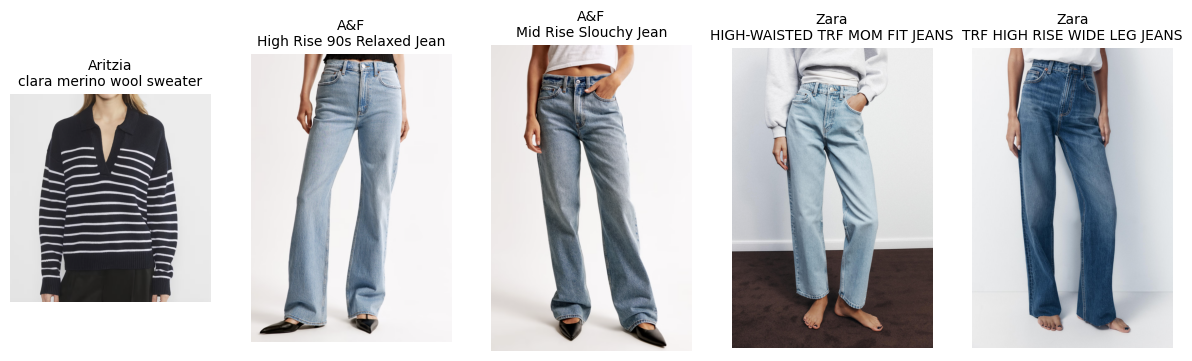

In [22]:
# Print out images corresponding with the top N recs
import matplotlib.pyplot as plt
from PIL import Image
import os

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (item_idx, score) in enumerate(recommended_items):
    img_path = df["image_path"].iloc[item_idx]  # Use item_idx instead of i
    print(i, item_idx, score, img_path)
    
    if os.path.isfile(img_path):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"{df['brand'].iloc[item_idx]}\n{df['name'].iloc[item_idx]}", fontsize=10)
        axes[i].axis("off")
    else:
        axes[i].set_title("Image Not Found", fontsize=10)
        axes[i].axis("off")

plt.show()

# Trying with updated matrix (+1/-1 encodings)

In [26]:
persona_df = persona_df.drop(columns=['image','Brianna','Average','user'])

KeyError: "['image', 'Brianna', 'Average', 'user'] not found in axis"

In [27]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def recommend_items(liked_indices, all_item_vectors, top_n=5):
    """
    Recommends top N items based on content-based filtering using cosine similarity.
    
    Parameters:
    - liked_indices (list): Indices of items the user likes.
    - all_item_vectors (numpy.ndarray): Matrix where each row is an item's feature vector.
    - top_n (int): Number of recommendations to return.
    
    Returns:
    - List of tuples (item_idx, score) sorted by descending similarity.
    """
    if not liked_indices:
        raise ValueError("Liked indices cannot be empty.")
    
    # Compute user preference vector by averaging liked items
    user_pref_vec = np.mean(all_item_vectors[liked_indices, :], axis=0, keepdims=True)
    
    # Calculate cosine similarity with all items
    scores = cosine_similarity(user_pref_vec, all_item_vectors).flatten()
    
    # Sort by descending similarity
    ranked_indices = np.argsort(scores)[::-1]
    
    # Exclude liked items
    exclude_set = set(liked_indices)
    filtered_ranked_indices = [idx for idx in ranked_indices if idx not in exclude_set]
    
    # Select top N recommendations
    recommendations = [(idx, scores[idx]) for idx in filtered_ranked_indices[:top_n]]
    
    return recommendations

def get_liked_indices(persona_df, persona):
    """
    Returns a list of indices where the persona rating is imputed and filtered.
    
    Parameters:
    - persona_df (pandas.DataFrame): DataFrame containing persona rankings.
    - persona (str): Column name representing the persona.
    
    Returns:
    - List of indices where the persona's rating is transformed to +/- 1.
    """
    if persona not in persona_df.columns:
        raise ValueError(f"Persona '{persona}' not found in persona_df.")
    
    persona_ratings = persona_df[persona].copy()
        
    # Impute values: +1 for ratings >= 7, -1 for lower ratings, leave NaNs as is
    persona_ratings = persona_ratings.apply(lambda x: 1 if x >= 7 else (-1 if pd.notna(x) else np.nan))
    
    # Return indices of non-null values
    return persona_ratings.dropna().index.tolist()


In [37]:
# Test with Vivian's preferences
# Can also test with "megan", "Laura", and "matt"
liked_indices = get_liked_indices(persona_df, "Matt")
print(liked_indices)

[0, 1, 5, 6, 8, 13, 14, 16, 18, 22, 23, 25, 26, 28, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


In [38]:
# Return recommendations
recommended_items = recommend_items(liked_indices, all_item_vectors, top_n=5)

for item_idx, score in recommended_items:
    print(f"Item idx {item_idx}, Score={score:.4f}")

Item idx 24, Score=0.8810
Item idx 50, Score=0.8795
Item idx 32, Score=0.8711
Item idx 58, Score=0.8703
Item idx 48, Score=0.8687


0 24 0.8809943432486187 ../dataset/26.png
1 50 0.8794687743238918 ../dataset/52.png
2 32 0.8711334807094617 ../dataset/34.png
3 58 0.8703373487254693 ../dataset/60.png
4 48 0.8686901715914829 ../dataset/50.png


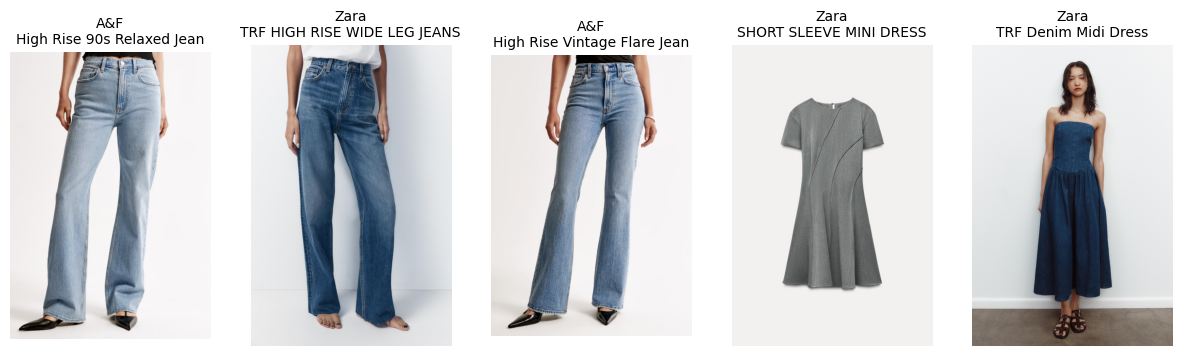

In [39]:
# Print out images corresponding with the top N recs
import matplotlib.pyplot as plt
from PIL import Image
import os

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (item_idx, score) in enumerate(recommended_items):
    img_path = df["image_path"].iloc[item_idx]  # Use item_idx instead of i
    print(i, item_idx, score, img_path)
    
    if os.path.isfile(img_path):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"{df['brand'].iloc[item_idx]}\n{df['name'].iloc[item_idx]}", fontsize=10)
        axes[i].axis("off")
    else:
        axes[i].set_title("Image Not Found", fontsize=10)
        axes[i].axis("off")

plt.show()